In [2]:
!pip install osmnx

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.4/107.4 kB 1.2 MB/s eta 0:00:00


# Network of City


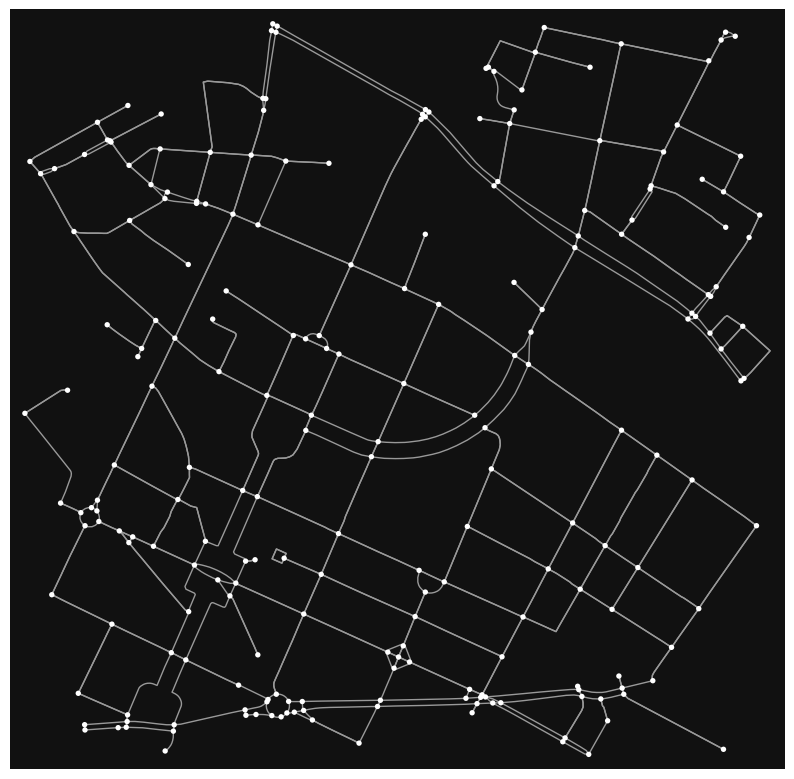

(<Figure size 1000x1000 with 1 Axes>, <Axes: >)

In [83]:
import osmnx as ox
import networkx as nx
import matplotlib.pyplot as plt

def plot_network(G):
    fig, ax = ox.plot_graph(G, figsize=(10,10))

    return fig, ax

berlin_network = ox.graph_from_address('Adalbertstraße 58, Berlin, Germany', dist=1000, network_type='drive')
berlin_network
plot_network(berlin_network)

# Traffic Simulator

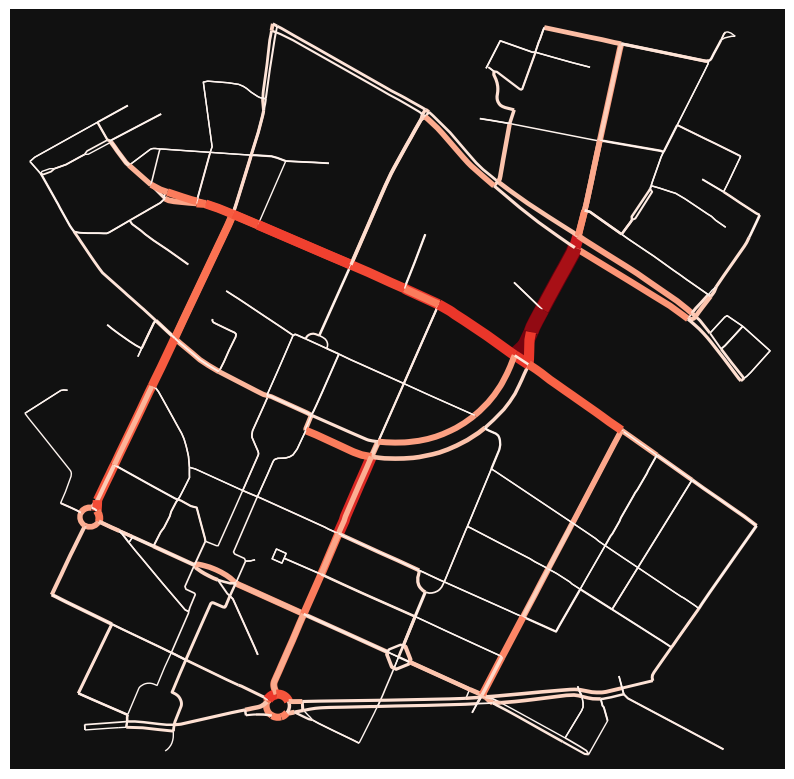

(<Figure size 1000x1000 with 1 Axes>, <Axes: >)

In [99]:
import osmnx as ox
import networkx as nx
import random
import numpy as np
import matplotlib.pyplot as plt
import re

class Car:
    """Represents a car in the traffic simulation."""

    def __init__(self, start, destination):
        """
        Initialize the Car object.

        Parameters:
            start (int): The starting node of the car.
            destination (int): The destination node of the car.
        """
        self.current_location = start
        self.destination = destination
        self.path = []

class TrafficSimulation:
    """Simulates traffic movement in the given graph."""

    def __init__(self, graph, num_cars=100, num_steps=10):
        """
        Initialize the TrafficSimulation object.

        Parameters:
            graph (networkx.MultiDiGraph): The graph representing the road network.
            num_cars (int): The number of cars in the simulation. Default is 100.
            num_steps (int): The number of simulation steps. Default is 10.
            jam_threshold (int): The number of allowed cars in an edge. Default is 5.
        """
        self.graph = graph
        self.num_cars = num_cars
        self.num_steps = num_steps
        self.cars = self.create_cars()
        # self.jam_threshold = jam_thresholh
        self.edge_jam_thresholds = self.calculate_edge_jam_thresholds()


    def create_cars(self):
        """Create cars with random starts and destinations."""
        nodes = list(self.graph.nodes())
        return [Car(random.choice(nodes), random.choice(nodes)) for _ in range(self.num_cars)]

    def simulate_traffic(self):
        """Simulate traffic movement."""
        for step in range(self.num_steps):
            self.move_cars()

            self.node_car_counts()

    def move_cars(self):
        """Move cars according to the traffic simulation rules."""
        for car in self.cars:
            if not car.path:
                try:
                    # Determine path based on shortest route
                    car.path = nx.shortest_path(self.graph, car.current_location, car.destination, weight="travel_time")
                except nx.NetworkXNoPath:
                    continue

            # Check if car has reached its destination
            if car.current_location == car.destination:
                continue

            #edge_jam_threshold = self.edge_jam_thresholds[(car.path[0], car.path[1])] # if self.edge_jam_thresholds[(car.current_location, car.path[0])] else 1
            next_node = car.path.pop(0)

            # print(edge_jam_threshold)

            edge_jam_threshold = self.edge_jam_thresholds.get((next_node, car.current_location))
            if edge_jam_threshold is None:  # Check both possible combinations
                edge_jam_threshold = self.edge_jam_thresholds.get((car.current_location , next_node))

            if edge_jam_threshold is None:
                edge_jam_threshold = 5  # Set a default threshold if not found



            cars_on_edge = sum(1 for c in self.cars if c.current_location == car.current_location and c.path and c.path[0] == next_node)

            if cars_on_edge > edge_jam_threshold:
                car.path.insert(0, next_node)  # Car stays in the same spot for the next iteration
            else:
                car.current_location = next_node

    def node_car_counts(self):
        """Counts the number of cars in each node"""
        node_counts = {node: 0 for node in self.graph.nodes()}

        # update the node_counts
        for car in self.cars:
            node_counts[car.current_location] += 1

        return node_counts


    def edge_car_counts(self):
        """Calculate the number of cars on each edge."""
        counts = {(u, v, k): 0 for u, v, k in self.graph.edges(keys=True)}
        for car in self.cars:
            if car.path:
                for u, v in zip(car.path[:-1], car.path[1:]):
                    counts[(u, v, 0)] += 1
        return counts

    def calculate_edge_jam_thresholds(self):
        """Calculate the jam threshold for each edge based on travel time."""

        edge_jam_thresholds = {}
        for u, v, k, data in self.graph.edges(keys=True, data=True):

            # add a 'travel time' attribute in each edge (for now, assume time is inversely proportional to speed limit, with a default of 30 km/h)
            speed = data.get("maxspeed", 30)
            if isinstance(speed, list):  # There can be multiple speed limits; take the first one as representative
                speed = speed[0]

            if isinstance(speed, str):
              speed = float(''.join(filter(str.isdigit, speed)))

            data["travel_time"] = data["length"] / (float(speed) * 1000/60)  # length in meters, speed in km/h, result in minutes

            travel_time = data.get("travel_time", 1)  # Default to 1 if travel_time is not available
            # Compute the threshold based on travel time, for example, multiply it by a factor
            # Adjust the factor (2) as needed
            threshold = int(travel_time * 100)
            edge_jam_thresholds[(u, v)] = threshold

        return edge_jam_thresholds


    def plot_network_with_traffic(self):
        """Plot the road network with traffic visualization."""
        edge_colors = []
        edge_widths = []

        counts = self.edge_car_counts()
        max_count = max(max(counts.values()), 1) # count the max_number of cars in the edges

        for u, v, k, data in self.graph.edges(keys=True, data=True):
            # # add a 'travel time' attribute in each edge (for now, assume time is inversely proportional to speed limit, with a default of 30 km/h)
            # speed = data.get("maxspeed", 30)
            # if isinstance(speed, list):  # There can be multiple speed limits; take the first one as representative
            #     speed = speed[0]

            # data["travel_time"] = data["length"] / (float(speed) * 1000/60)  # length in meters, speed in km/h, result in minutes

            count = counts.get((u, v, k), 0)
            edge_colors.append(plt.cm.Reds(count / max_count))  # Adjust colormap based on count
            edge_widths.append(1 + (count/max_count)*10)  # Adjust edge width based on count, in order to prevent big widhts, we set a cap of 10

        fig, ax = ox.plot_graph(self.graph, figsize=(10,10), edge_color=edge_colors, edge_linewidth=edge_widths, node_size=0)
        return fig, ax


G = ox.graph_from_address('Adalbertstraße 58, Berlin, Germany', dist=1000, network_type='drive')

simulation = TrafficSimulation(G, 1000, 100)
simulation.simulate_traffic()
simulation.plot_network_with_traffic()


# Iterative Simulation

In [47]:
from tqdm import tqdm

# Collect the number of cars on edges and in nodes for each run
def run_multiple_simulations(G, cars, steps, num_runs):
    simulation = TrafficSimulation(G, cars, steps)
    cars_on_edge = []
    cars_in_node = []
    for _ in tqdm(range(num_runs)):
        simulation.simulate_traffic()
        cars_on_edge.append(simulation.edge_car_counts())
        cars_in_node.append(simulation.node_car_counts())
    return cars_on_edge, cars_in_node


G = ox.graph_from_address('Adalbertstraße 58, Berlin, Germany', dist=1000, network_type='drive')
num_runs = 100
cars = 1000
steps = 100
cars_on_edge, cars_in_node = run_multiple_simulations(G, cars, steps, num_runs)


100%|██████████| 100/100 [10:37<00:00,  6.38s/it]


# Compute Average Number of Cars in Edges and Nodes

In [48]:
def calculate_average(data):
    average_congestion = {}
    for run_data in data:
        for edge, count in run_data.items():
            if edge in average_congestion:
                average_congestion[edge] += count
            else:
                average_congestion[edge] = count
    for edge, count in average_congestion.items():
        average_congestion[edge] = count / len(data)
    return average_congestion

# Calculate average congestion
average_cars_edge = calculate_average(cars_on_edge)
average_cars_node = calculate_average(cars_in_node)

# Network Metrics

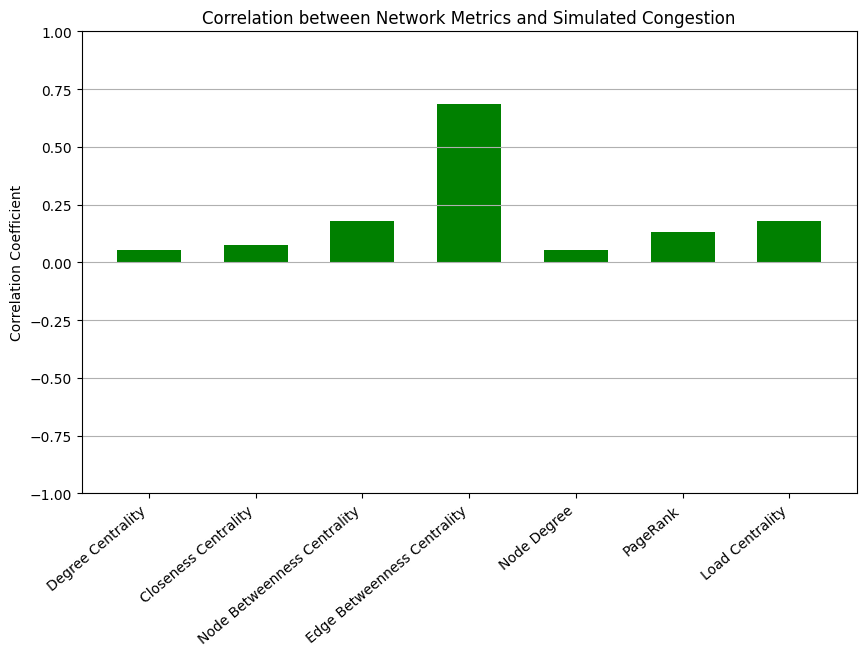

In [85]:
# Calculate Network Metrics

def correlation_metrics(G, average_cars_edge, average_cars_node):
    # edge
    edge_betweenness_centrality = nx.edge_betweenness_centrality(G)

    # nodes
    betweenness_centrality = nx.betweenness_centrality(G)
    degree_centrality = nx.degree_centrality(G)
    closeness_centrality = nx.closeness_centrality(G)
    node_degrees = dict(G.degree())
    pagerank = nx.pagerank(G)
    load_centrality = nx.load_centrality(G)

    # Calculate correlations
    corr_edge_betweenness = np.corrcoef(list(edge_betweenness_centrality.values()), list(average_cars_edge.values()))[0, 1]
    corr_betweenness = np.corrcoef(list(betweenness_centrality.values()), list(average_cars_node.values()))[0, 1]
    corr_degree_central = np.corrcoef(list(degree_centrality.values()), list(average_cars_node.values()))[0, 1]
    corr_closeness = np.corrcoef(list(closeness_centrality.values()), list(average_cars_node.values()))[0, 1]
    corr_degree = np.corrcoef(list(node_degrees.values()), list(average_cars_node.values()))[0, 1]
    corr_pagerank = np.corrcoef(list(pagerank.values()), list(average_cars_node.values()))[0, 1]
    corr_load_centrality = np.corrcoef(list(load_centrality.values()), list(average_cars_node.values()))[0, 1]

    # Plot correlations
    plt.figure(figsize=(10, 6))
    plt.bar(['Degree Centrality', 'Closeness Centrality', 'Node Betweenness Centrality', 'Edge Betweenness Centrality', 'Node Degree', 'PageRank', 'Load Centrality'],
            [corr_degree, corr_closeness, corr_betweenness, corr_edge_betweenness, corr_degree, corr_pagerank, corr_load_centrality], color='green', width=0.6)

    plt.xticks(rotation=40, ha='right')

    plt.title('Correlation between Network Metrics and Simulated Congestion')
    plt.ylabel('Correlation Coefficient')
    plt.ylim(-1, 1)  # Set y-axis limits to show correlation coefficient range
    plt.grid(axis='y')
    plt.show()

correlation_metrics(G, average_cars_edge, average_cars_node)

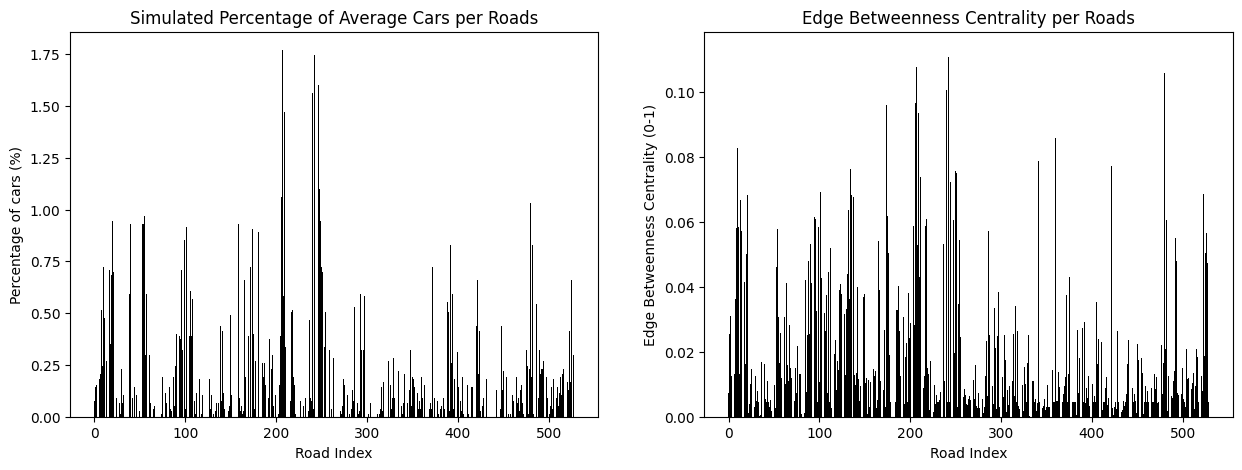

In [89]:
# Simulation
normalized_car_edges = {}
for edge, count in average_cars_edge.items():
    normalized_car_edges[edge] = count/sum(average_cars_edge.values()) * 100

def ebc_and_car_edges(G, normalized_car_edges):
    '''Compute their edge betweenness centrality and percentage of number of cars '''
    edge_betweenness_centrality = nx.edge_betweenness_centrality(G)

    cars = range(len(normalized_car_edges.keys()))
    road_index = normalized_car_edges.values()

    # Theretical Value
    road_index2 = range(len(edge_betweenness_centrality.keys()))
    edge_cb = edge_betweenness_centrality.values()

    # Plotting
    # Simulation
    plt.figure(figsize=(15, 5))
    plt.subplot(1,2,1)
    plt.bar(cars, road_index, color='black')
    plt.xlabel('Road Index')
    plt.ylabel('Percentage of cars (%)')
    plt.title('Simulated Percentage of Average Cars per Roads')

    # Theoretical
    plt.subplot(1,2,2)
    plt.bar(road_index2, edge_cb, color='black')
    plt.xlabel('Road Index')
    plt.ylabel('Edge Betweenness Centrality (0-1)')
    plt.title('Edge Betweenness Centrality per Roads')

    plt.show()

ebc_and_car_edges(G, normalized_car_edges)

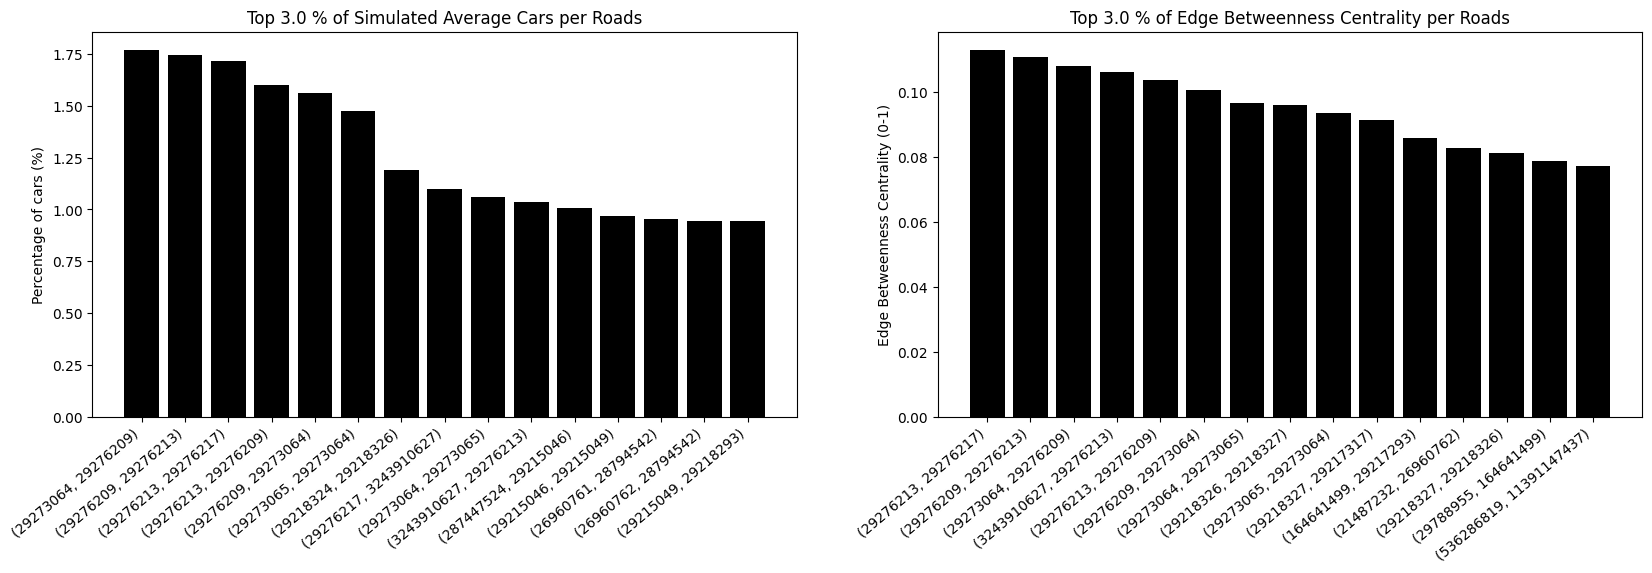

Shared values: 53.333333333333336 %


In [91]:
# Top Percentage

def calculate_top_values(G, normalized_car_edges, percentage=0.03):
    '''Calculate the plots for the top values of
    edge betweenness centrality and normalized number of cars'''

    edge_betweenness_centrality = nx.edge_betweenness_centrality(G)
    # Simulation
    sorted_car_edges = sorted(normalized_car_edges.items(), key=lambda x: x[1], reverse=True)
    top_percentage_simulation = int(len(sorted_car_edges) * percentage)
    top_simulation = sorted_car_edges[:top_percentage_simulation]

    plt.figure(figsize=(20, 5))

    plt.subplot(1,2,1)
    plt.bar([str(key[0][:-1]) for key in top_simulation],  [top_simulation[i][1] for i in range(len(top_simulation))], color='black')

    plt.xticks(rotation=40, ha='right')
    plt.ylabel('Percentage of cars (%)')
    plt.title(f'Top {percentage*100} % of Simulated Average Cars per Roads')

    # Theoretical
    sorted_betweenness = sorted(edge_betweenness_centrality.items(), key=lambda x: x[1], reverse=True)
    top_percentage_betweenness = int(len(sorted_betweenness) * percentage)
    top_betweenness = sorted_betweenness[:top_percentage_betweenness]

    plt.subplot(1,2,2)
    plt.bar([str(key[0][:-1]) for key in top_betweenness],  [top_betweenness[i][1] for i in range(len(top_betweenness))], color='black')

    plt.xticks(rotation=40, ha='right')
    plt.ylabel('Edge Betweenness Centrality (0-1)')
    plt.title(f'Top {percentage*100} % of Edge Betweenness Centrality per Roads')

    plt.show()

    set1 = set(str(key[0][:-1]) for key in top_simulation)
    set2 = set([str(key[0][:-1]) for key in top_betweenness])
    intersection = set1.intersection(set2)

    print('Shared values:', len(intersection)/len(set1)*100, '%')

calculate_top_values(G, normalized_car_edges)

# London Traffic Simulation

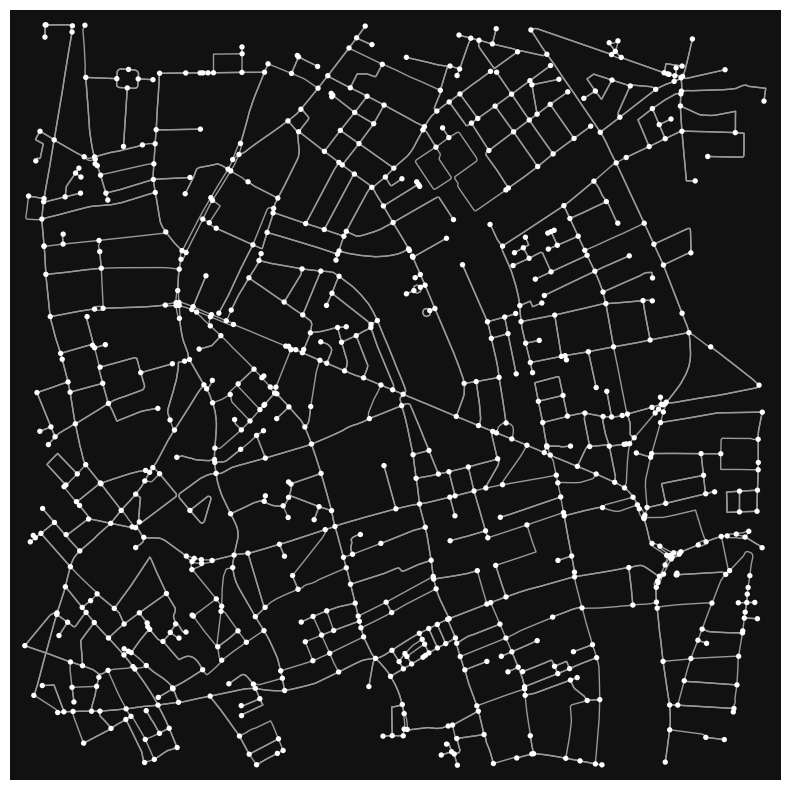

(<Figure size 1000x1000 with 1 Axes>, <Axes: >)

In [100]:
london_network = ox.graph_from_address('City Road, London, England', dist=1000, network_type='drive')
plot_network(london_network)

In [101]:
num_runs = 100
cars = 1000
steps = 100
cars_on_edge, cars_in_node = run_multiple_simulations(london_network, cars, steps, num_runs)

100%|██████████| 100/100 [10:57<00:00,  6.58s/it]


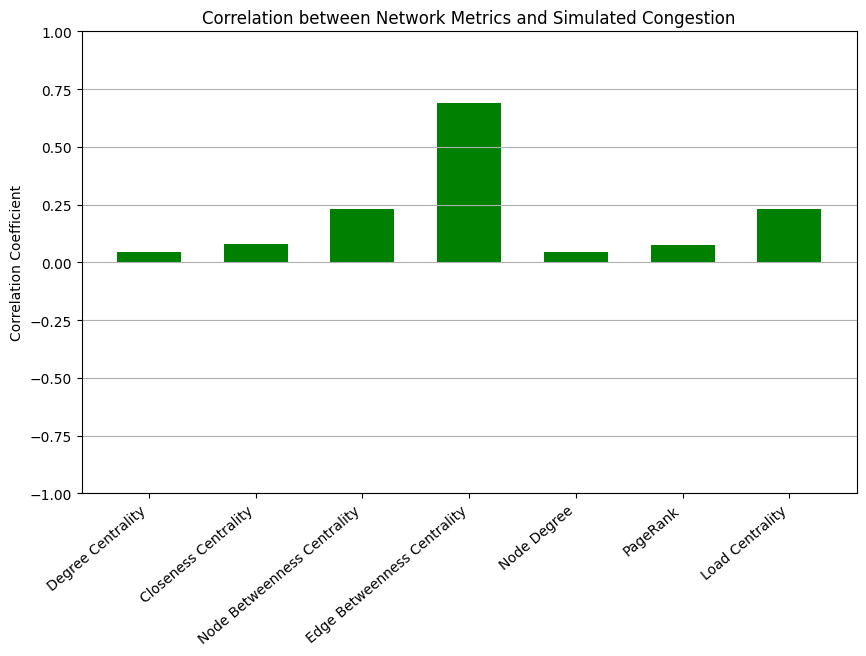

In [102]:
# Calculate average congestion
average_cars_edge = calculate_average(cars_on_edge)
average_cars_node = calculate_average(cars_in_node)

# Plot Correlation Coefficients
correlation_metrics(london_network, average_cars_edge, average_cars_node)

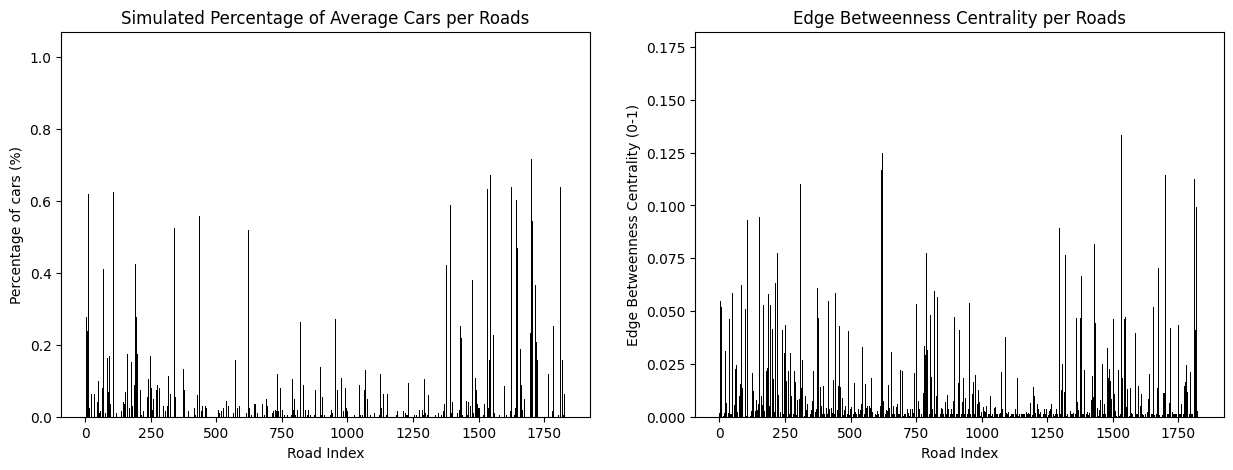

In [103]:
normalized_car_edges = {}
for edge, count in average_cars_edge.items():
    normalized_car_edges[edge] = count/sum(average_cars_edge.values()) * 100

ebc_and_car_edges(london_network, normalized_car_edges)

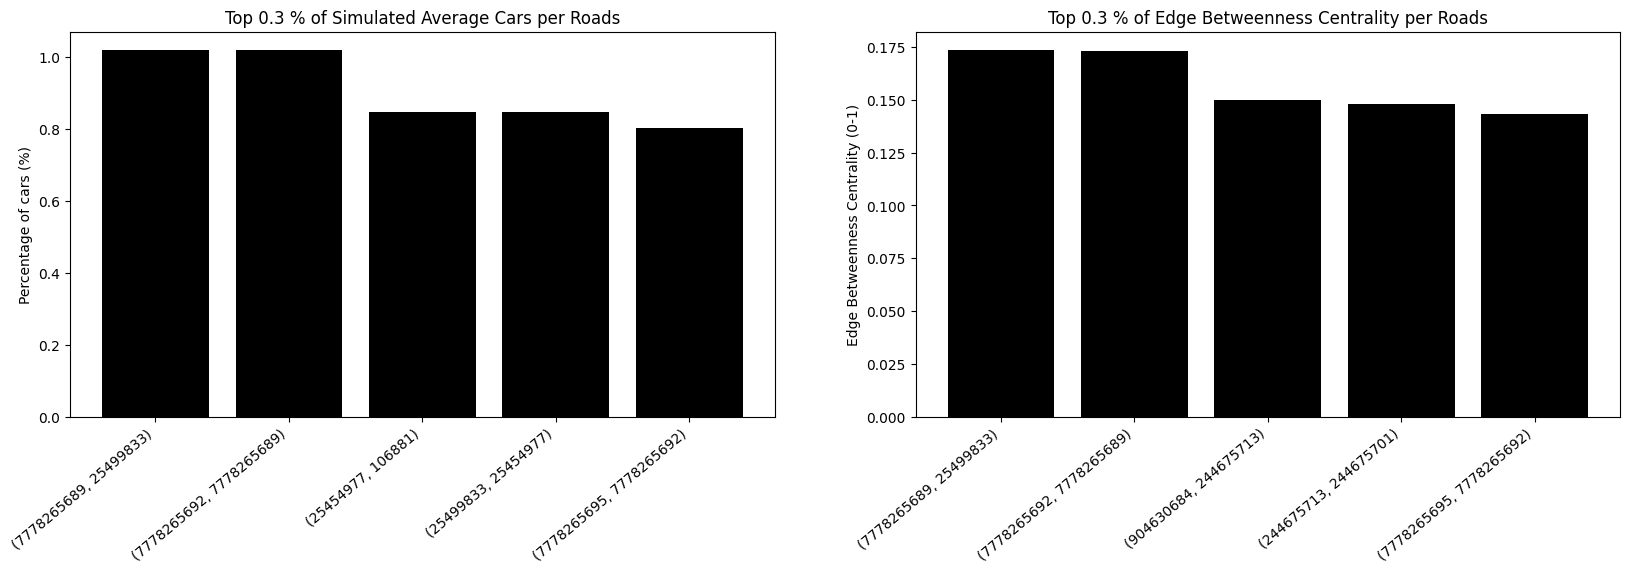

Shared values: 60.0 %


In [108]:
calculate_top_values(london_network, normalized_car_edges, 0.003)

# Showcase edges

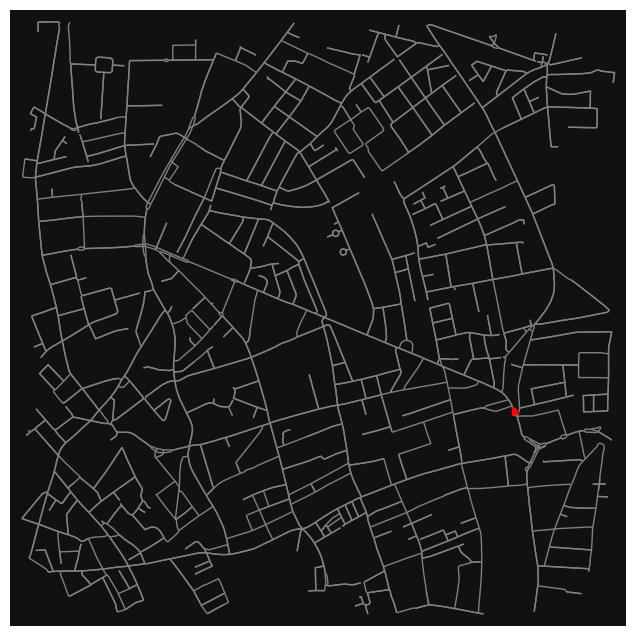

In [137]:
import networkx as nx
import osmnx as ox
import matplotlib.pyplot as plt

def plot_network(G, edge_to_highlight=None):
    # Plot the entire network
    ox.plot_graph(G, edge_color='gray', edge_linewidth=1, node_size=0, show=False)

    if edge_to_highlight:
        u, v = edge_to_highlight
        if G.has_edge(u, v):
            # Get the positions of nodes
            node_positions = {node: (data['x'], data['y']) for node, data in G.nodes(data=True)}
            # Highlight the specified edge
            nx.draw_networkx_edges(G, pos=node_positions, edgelist=[(u, v)], edge_color='red', width=2)

    plt.show()

# Create the London network
london_network = ox.graph_from_address('City Road, London, England', dist=1000, network_type='drive')

# Plot the network with the most congested edge
plot_network(london_network, edge_to_highlight=(7778265689, 25499833))  # Example edge
